In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .config('spark.master', "local[20]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         # uncomment if beta-jupyterhub proxies are working again.  otherwise, tunnel
         #.config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())
spark


In [3]:
from axs.catalog import AxsCatalog
catalog = AxsCatalog(spark)

In [49]:
#catalog.list_table_names()

In [5]:
ztf = catalog.load('ztf_dr14')

In [48]:
#ztf.columns

In [11]:
ra = 121.59226  
dec =  21.44102

In [19]:
#  30 arcsec  ==> 0.008333  degree (  30 / 3600 )
# 3 arcsec ==> 0.00083 degree (3/3600) 
offset = 0.00083
ztf_pd2 = ztf.select(ztf.columns).where( 
    (ztf['dec'] >dec-offset ) & (ztf['dec']  < dec+offset) \
& (ra-offset < ztf['ra']) & ( ztf['ra']< ra+offset)
                                      ).limit(1000).toPandas()

Text(0.5, 0, 'Time')

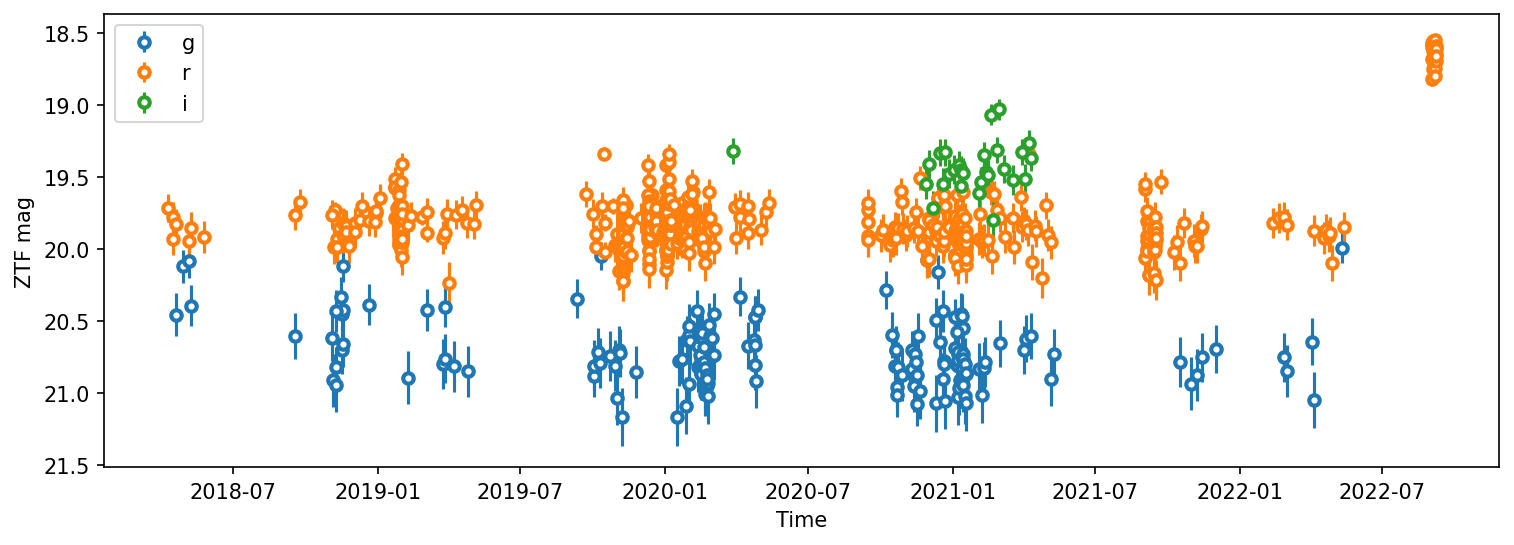

In [52]:
import matplotlib.pyplot as plt
from astropy.time import Time
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=150)
#days_since = ztf_pd2['mjd_r'][0]-min(ztf_pd2['mjd_r'][0])
i=0
for f in 'gri':
    mjd =  Time(ztf_pd2[f'mjd_{f}'][0], format='mjd')
    ax.errorbar(mjd.to_datetime(),
                        ztf_pd2[f'mag_{f}'][0],#+0.5*i,
                        ztf_pd2[f'magerr_{f}'][0],
                        fmt=".",  markersize=10, mfc='white', mew=2 , label=f,
                                )
    i+=1 
ax.legend()
ax.invert_yaxis() 
ax.set_ylabel('ZTF mag')
ax.set_xlabel('Time')